In [1]:
# My neural net model
from neural_net import neural_net
from vis_utils import plotStats, plotData
from gradient_utils import gradient_difference
from tuning_utils import tuning_hyper_parameter
from vis_utils import visualize_grid_withoutRGB, visualize_grid

# Linear algebra library
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 5) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
def show_net_weights_rgb(net):
    plt.rcParams['figure.figsize'] = (12, 12) # set default size of plots
    plt.figure(figsize=(7,7))
    W1 = net.function_params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    W1 = W1[0:5].reshape(5, 32, 32, 3)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

In [3]:
from features import color_histogram_hsv, hog_feature
from data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'data/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    mean_image = np.mean(X_train, axis=0)
    
    return X_train, y_train, X_val, y_val, X_test, y_test, mean_image

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test, mean_image = get_CIFAR10_data()
print('Finish Loading Datasets')

Finish Loading Datasets


In [4]:
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
from features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns, verbose = True)
X_test_feats = extract_features(X_test, feature_fns, verbose = True)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

In [6]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(f'train data feats shape {X_train_feats.shape}')
print(f'val data feats shape {X_val_feats.shape}')
print(f'test data feats shape {X_test_feats.shape}')

(49000, 155)
train data feats shape (49000, 154)
val data feats shape (1000, 154)
test data feats shape (1000, 154)


In [27]:
net_params = {'il':X_train_feats.shape[1],'hl1':416,'hl2':416,'ol':10}
# activ_function = 'Sigmoid'
# cost_function = 'Entropy_Loss'
activ_function = 'ReLu'
cost_function = 'SoftMax'
net = neural_net(net_params, activ_function, cost_function, std = 1)

results = net.train_sgd_momentum(X_train_feats, y_train, X_val_feats, y_val, learning_rate=2.590628e-01, 
                                 learning_rate_decay=0.999, reg = 4.789351e-07,
                                 max_iter = 5000, batch_size = 200, verbose =  True, rho = 0.50, stochastic = True, epoch = 50)

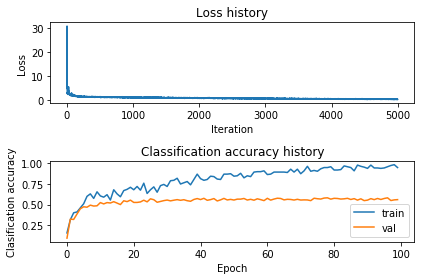

accuracy in training set : 86.5204081632653
accuracy in validation set : 54.900000000000006
accuracy in validation set : 54.300000000000004


In [28]:
plotStats(results)
y_pred = net.predict(X_train_feats)
print(f'accuracy in training set : {(y_pred == y_train).mean() *100}')
y_pred_val = net.predict(X_val_feats)
print(f'accuracy in validation set : {(y_pred_val == y_val).mean() *100}')
y_pred_test = net.predict(X_test_feats)
print(f'accuracy in validation set : {(y_pred_test == y_test).mean() *100}')

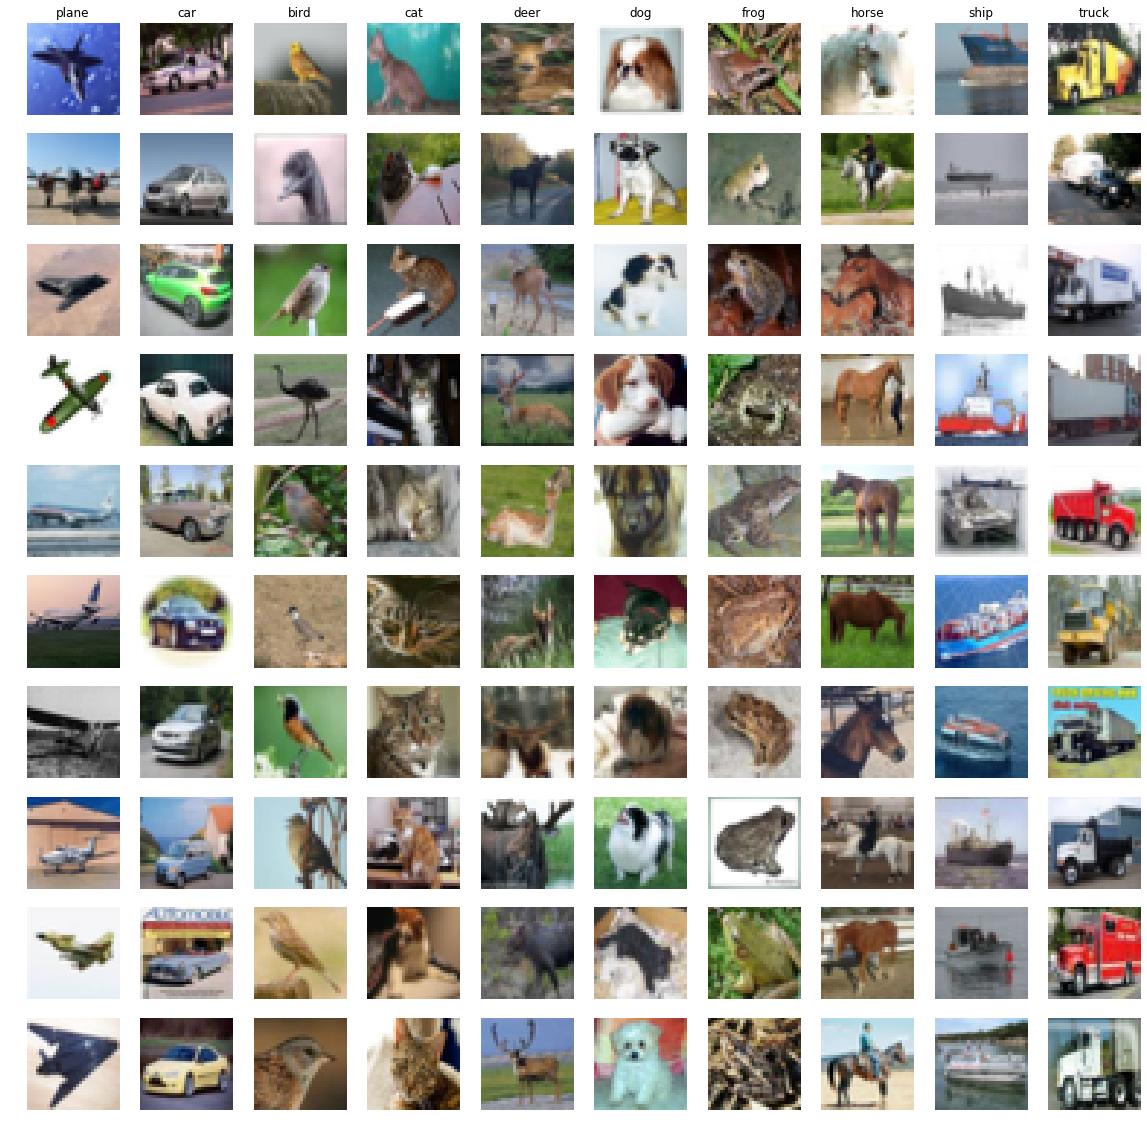

In [33]:
plt.rcParams['figure.figsize'] = (20, 20) # set default size of plots
#plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
examples_per_class = 10
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test == cls) & (y_pred_test == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

In [39]:
best_net, net_params, lr, reg = tuning_hyper_parameter(net_params , X_train_feats, y_train, X_val_feats, y_val, h_min = 5,
                                           h_max = 500, reg_min = -7, reg_max = 2, lr_min = -4, lr_max = -1,max_count = 10,
                                           epoch = 20, max_iter = 5000,method = 'sgd', batch_size = 200, learning_decay = 0.99, 
                                           hidden_layers = 1, activation_function = 'ReLu', cost_function = 'SoftMax')


 Tuning with stochastic gradient descent



{'il': 154, 'hl1': 405, 'hl2': 416, 'ol': 10}
lr 0.00099 reg 0.0 loss 1.649 train accuracy: 0.421734693877551 val accuracy: 0.415

 Tuning with stochastic gradient descent



{'il': 154, 'hl1': 378, 'hl2': 416, 'ol': 10}
lr 0.0378 reg 3e-05 loss 1.1675 train accuracy: 0.6098163265306122 val accuracy: 0.552

 Tuning with stochastic gradient descent



{'il': 154, 'hl1': 163, 'hl2': 416, 'ol': 10}
lr 0.02285 reg 9e-05 loss 1.36692 train accuracy: 0.5567142857142857 val accuracy: 0.505

 Tuning with stochastic gradient descent



{'il': 154, 'hl1': 379, 'hl2': 416, 'ol': 10}
lr 0.00011 reg 0.00052 loss 3.19674 train accuracy: 0.19110204081632653 val accuracy: 0.194

 Tuning with stochastic gradient descent



{'il': 154, 'hl1': 42, 'hl2': 416, 'ol': 10}
lr 0.00397 reg 4e-05 loss 1.62459 train accuracy: 0.42859183673469387 val accuracy: 0.406

 Tuning with stochastic gradient descent



{'il': 154, 'hl1': 47, 'hl2': 416, 'ol': 10}
lr 0.0018 reg 1.82483 loss 2.35964 train accuracy: 0.09995918367346938 val accuracy: 0.102

 Tuning with stochastic gradient descent



{'il': 154, 'hl1': 242, 'hl2': 416, 'ol': 10}
lr 0.00013 reg 0.15039 loss 177.2189 train accuracy: 0.18908163265306122 val accuracy: 0.183

 Tuning with stochastic gradient descent



{'il': 154, 'hl1': 131, 'hl2': 416, 'ol': 10}
lr 0.00019 reg 44.35384 loss 2.80207 train accuracy: 0.10004081632653061 val accuracy: 0.098

 Tuning with stochastic gradient descent



{'il': 154, 'hl1': 496, 'hl2': 416, 'ol': 10}
lr 0.02087 reg 8e-05 loss 1.34065 train accuracy: 0.579469387755102 val accuracy: 0.515

 Tuning with stochastic gradient descent



{'il': 154, 'hl1': 158, 'hl2': 416, 'ol': 10}
lr 0.03432 reg 0.00411 loss 3.07365 train accuracy: 0.557265306122449 val accuracy: 0.538

 best validation accuracy achieved: 0.552000


In [43]:
results = best_net.train_stochastic_gradient_descent(X_train_feats, y_train, X_val_feats, y_val, learning_rate=2.590628e-01, 
                                 learning_rate_decay=0.999, reg = 3e-05,
                                 max_iter = 10000, batch_size = 200, verbose =  True, epoch = 50)

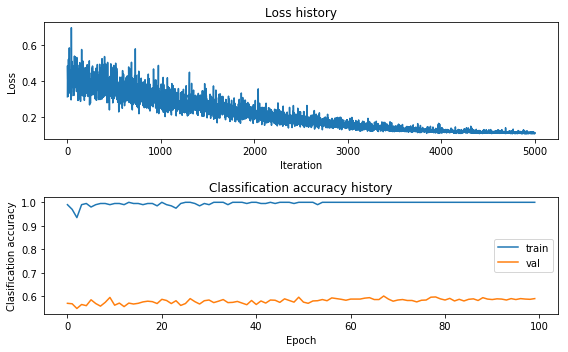

accuracy in training set : 99.9734693877551
accuracy in validation set : 58.5
accuracy in validation set : 56.89999999999999


In [45]:
plotStats(results)
y_pred = best_net.predict(X_train_feats)
print(f'accuracy in training set : {(y_pred == y_train).mean() *100}')
y_pred_val = best_net.predict(X_val_feats)
print(f'accuracy in validation set : {(y_pred_val == y_val).mean() *100}')
y_pred_test = best_net.predict(X_test_feats)
print(f'accuracy in validation set : {(y_pred_test == y_test).mean() *100}')


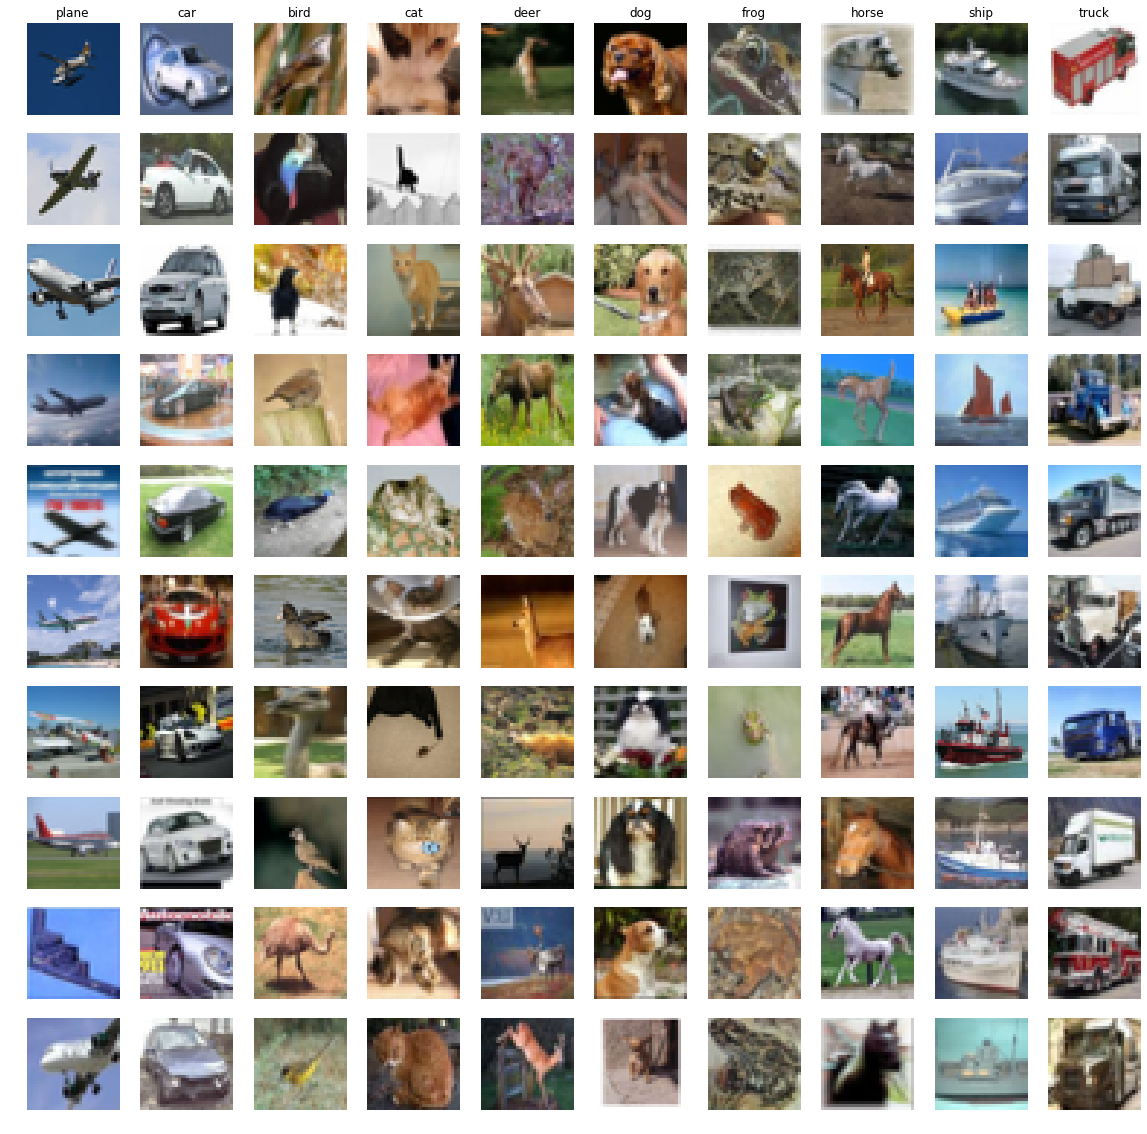

In [48]:
plt.rcParams['figure.figsize'] = (20, 20) # set default size of plots
#plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
examples_per_class = 10
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_train == cls) & (y_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

In [27]:
from data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):

    # Load the raw CIFAR-10 data
    cifar10_dir = 'data/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test, mean_image


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    del X, y
    print('Clear previously loaded data.')
except:
    pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, mean_image = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Finisth Loading Images')

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)
Finisth Loading Images


In [39]:
net_params = {'il':X_train.shape[1],'hl1':400,'hl2':400,'ol':10}
# activ_function = 'Sigmoid'
# cost_function = 'Entropy_Loss'
activ_function = 'ReLu'
cost_function = 'SoftMax'
net = neural_net(net_params, activ_function, cost_function, std = 1)

results = net.train_stochastic_gradient_descent(X_train, y_train, X_val, y_val, learning_rate=3.9e-04, 
                                 learning_rate_decay=0.999, reg = 4.789351e-04,
                                 max_iter = 10000, batch_size = 200, verbose =  True, epoch = 500)

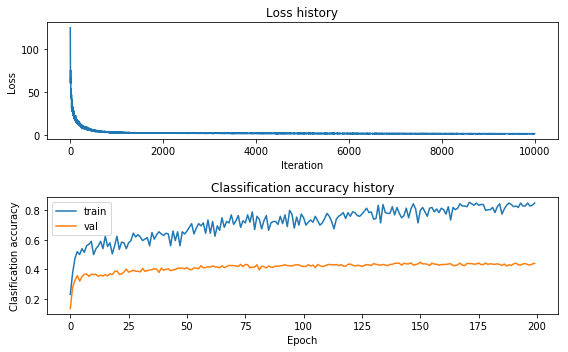

accuracy in training set : 80.46530612244898
accuracy in validation set : 44.1
accuracy in validation set : 40.5


In [40]:
plotStats(results)
y_pred = net.predict(X_train)
print(f'accuracy in training set : {(y_pred == y_train).mean() *100}')
y_pred_val = net.predict(X_val)
print(f'accuracy in validation set : {(y_pred_val == y_val).mean() *100}')
y_pred_test = net.predict(X_test)
print(f'accuracy in validation set : {(y_pred_test == y_test).mean() *100}')

In [42]:
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3) + mean_image

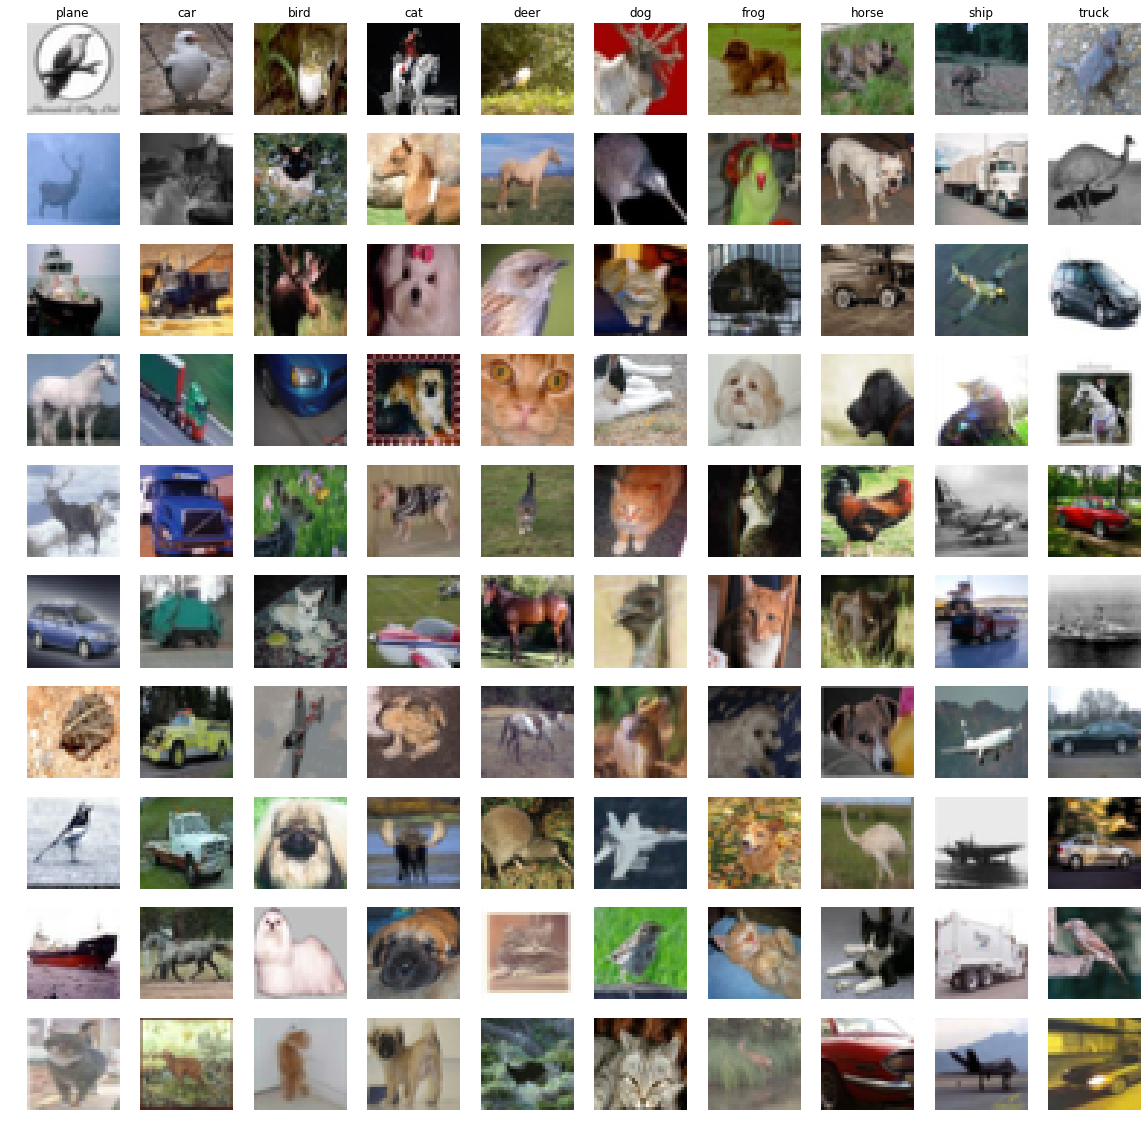

In [43]:
plt.rcParams['figure.figsize'] = (20, 20) # set default size of plots
#plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
examples_per_class = 10
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_train != cls) & (y_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()